In [48]:
#!/.conda/envs/learn python
# -*- coding: utf-8 -*-

"""
多类别精度评定

预测结果和真值标签均为栅格且带有地理坐标系
~~~~~~~~~~~~~~~~
code by wHy
Aerospace Information Research Institute, Chinese Academy of Sciences
wanghaoyu191@mails.ucas.ac.cn
"""

'\n多类别精度评定\n\n预测结果和真值标签均为栅格且带有地理坐标系\n~~~~~~~~~~~~~~~~\ncode by wHy\nAerospace Information Research Institute, Chinese Academy of Sciences\nwanghaoyu191@mails.ucas.ac.cn\n'

In [49]:
import os
from statistics import mean
import sys
import fnmatch
import numpy as np
import gdal
import ogr
import osr
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [50]:
os.environ['GDAL_DATA'] = r'C:\Users\75198\.conda\envs\learn\Lib\site-packages\GDAL-2.4.1-py3.6-win-amd64.egg-info\gata-data' #防止报error4错误

ground_truth_path = r'E:\xinjiang_huyang_hongliu\Huyang_test_0808\1-raster_label\1-raster_label_haze_lv2_for_clear_Evaluation' # 存储真值标签的文件夹 真值标签应为栅格 带有地理坐标系
predict_path = r'E:\xinjiang_huyang_hongliu\Huyang_test_0808\3-predict_result\3-predict_result_Unet-huyang_clear_mix_sim_haze_ATSC+convw+pn_LV2_rate_0.1_230424' # 存储预测栅格的文件 带有地理坐标系

'''为了省事自动检索预测结果文件夹下的tif影像'''
pre_pic_name = fnmatch.filter(os.listdir(predict_path), '*.tif')
pre_pic_name_full = predict_path + '/' + pre_pic_name[0][:-4] + '.tif'

im_data_pre_full = []
im_data_true_full = []
listpic = fnmatch.filter(os.listdir(ground_truth_path), '*.tif')
for gt_name in listpic:
    gt_full_path = ground_truth_path + '/' + gt_name[:-4] + '.tif'
    '''以真值标签为参考，从预测栅格文件中裁剪出待评定部分'''
    # 获取真值标签地理坐标信息
    input_small = gdal.Open(gt_full_path)
    geotransform_small = input_small.GetGeoTransform()
    proj_small = input_small.GetProjection()
    srs_small = osr.SpatialReference()
    srs_small.ImportFromWkt(proj_small)

    # 获取小的栅格影像的左上角和右下角地理坐标
    xmin_small = geotransform_small[0]
    ymax_small = geotransform_small[3]
    xmax_small = geotransform_small[0] + geotransform_small[1] * input_small.RasterXSize
    ymin_small = geotransform_small[3] + geotransform_small[5] * input_small.RasterYSize

    # 打开大的栅格影像
    input_large = gdal.Open(pre_pic_name_full)

    # 获取大的栅格影像的地理参考信息
    geotransform_large = input_large.GetGeoTransform()
    proj_large = input_large.GetProjection()
    srs_large = osr.SpatialReference()
    srs_large.ImportFromWkt(proj_large)

    # 计算小的栅格影像在大的栅格影像中的位置
    x_offset = int((xmin_small - geotransform_large[0]) / geotransform_large[1])
    y_offset = int((geotransform_large[3] - ymax_small) / abs(geotransform_large[5]))

    print(x_offset, y_offset)

    # 定义裁剪窗口大小
    win_size = input_small.RasterXSize

    # 计算裁剪窗口范围
    xmin = geotransform_large[0] + x_offset * geotransform_large[1]
    ymax = geotransform_large[3] - y_offset * abs(geotransform_large[5])
    xmax = xmin + win_size * geotransform_large[1]
    ymin = ymax - win_size * abs(geotransform_large[5])

    # 整理数据
    im_data_pre = input_large.ReadAsArray(x_offset, y_offset, win_size, win_size)  # 读取预测结果对应区域的数据
    im_data_true = input_small.ReadAsArray(0, 0, win_size, win_size) # 读取真值标签区域数据

    print(im_data_pre.shape, im_data_true.shape)
    print(type(im_data_pre))

    im_data_pre = list(im_data_pre.reshape(-1)) # 展平为一维
    im_data_true = list(im_data_true.reshape(-1)) # 展平为一维

    im_data_pre_full = im_data_pre_full + im_data_pre # 链接
    im_data_true_full = im_data_true_full + im_data_true

    
unique_pre, count_pre=np.unique(im_data_pre_full,return_counts=True)
data_count_pre=dict(zip(unique_pre, count_pre))
unique_true,count_true=np.unique(im_data_true_full,return_counts=True)
data_count_true=dict(zip(unique_true,count_true))
print(data_count_pre)
print(data_count_true)



5043 6414
(384, 384) (384, 384)
<class 'numpy.ndarray'>
6995 6685
(384, 384) (384, 384)
<class 'numpy.ndarray'>
4799 5228
(384, 384) (384, 384)
<class 'numpy.ndarray'>
{0: 366646, 1: 44539, 2: 31183}
{0: 377056, 1: 38630, 2: 26682}


Confusion matrix:
[[0.95270994 0.02910178 0.01818828]
 [0.04561222 0.80266632 0.15172146]
 [0.21209055 0.09590735 0.6920021 ]] 

Accuracy: 0.8950534396701388
Balanced Accuracy: 0.7836698686314065
My Balanced Accuracy: 0.8157927875315707
Precision: 0.6989804309614843
Recall: 0.7836698686314065
F1 Score: 0.733374951515663


              precision    recall  f1-score   support

  background       0.98      0.93      0.95    122109
     populus       0.70      0.81      0.75     17389
  red_willow       0.42      0.62      0.50      7958

    accuracy                           0.90    147456
   macro avg       0.70      0.78      0.73    147456
weighted avg       0.91      0.90      0.90    147456



<Figure size 432x288 with 0 Axes>

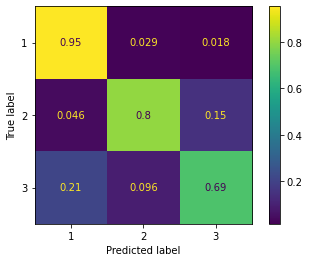

In [51]:
'''精度评定部分'''
'''计算混淆矩阵'''
cm = confusion_matrix(im_data_true_full, im_data_pre_full, normalize='true')
print("Confusion matrix:")
print(cm, '\n')
accuracy = accuracy_score(im_data_true, im_data_pre)
balanced_accuracy = balanced_accuracy_score(im_data_true, im_data_pre)
precision = precision_score(im_data_true, im_data_pre, average='macro', zero_division=0) # 'macro' 表示对所有类别的精确率求平均值
recall = recall_score(im_data_true, im_data_pre, average='macro', zero_division=0) # 'macro' 表示对所有类别的召回率求平均值
f1 = f1_score(im_data_true, im_data_pre, average='macro', zero_division=0)  # 'macro' 表示对所有类别的 F1 分数求平均值

# 输出综合精度指标
print('Accuracy:', accuracy)
print('Balanced Accuracy:', balanced_accuracy)
balanced_accuracy = (cm[0][0]+ cm[1][1] + cm[2][2])/3
print('My Balanced Accuracy:', balanced_accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('\n')

# 生成分类报告
report = classification_report(im_data_true, im_data_pre, target_names=['background', 'populus', 'red_willow'])
print(report)

# 画出混淆矩阵
# ConfusionMatrixDisplay 需要的参数: confusion_matrix(混淆矩阵), display_labels(标签名称列表)
labels = {'1', '2', '3'}
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
plt.clf()
